A model with real unknowns has been initialized
Interval (0, 1.0) has been meshed
Domain has been set
Domain is set and contains 1 mesh(es):
=== on mesh 0 of dim 1
* Subdomains are: {'Omega': 1}
* Boundaries are: {'Gamma_Left': 10, 'Gamma_Right': 11}
domain: Interval has been set
state: q has been added
state: p has been added
port: q has been added 
costate: e_q has been added to state: q
state: q has new costate: e_q
port: p has been added 
costate: e_p has been added to state: p
state: p has new costate: e_p
port: Boundary control (left) has been added on region 10
port: Boundary control (right) has been added on region 11
FEM_PK(1,2) has been set for port q
FEM_PK(1,1) has been set for port p
FEM_PK(1,1) has been set for port Boundary control (left)
FEM_PK(1,1) has been set for port Boundary control (right)
T has been added to port: q
T has been set to 1 in port: q
T has been initialized with the FEM of port: q
rho has been added to port: p
rho has been set to 1 + x*(1-x) in port: 

message from gf_mesh_get follow:
gfMesh object in dimension 1 with 101 points and 100 elements

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 1 with 101 points, 100 elements and 201 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 1 with 101 points, 100 elements and 101 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 1 with 101 points, 100 elements and 101 degrees of freedom

message from gf_mesh_fem_get follow:
gfMeshFem object in dimension 1 with 101 points, 100 elements and 101 degrees of freedom

Parameter T has been evaluated with the fem of port ' q ', with expression: 1
Parameter rho has been evaluated with the fem of port ' p ', with expression: 1 + x*(1-x)
i=       0 t=       0 * (0s)   dt=    0.01        
i=       6 t=0.0120268 * (0s)   dt=0.0027987          
i=      10 t=0.0244885 * (0s)   dt=0.00327865        
i=      13 t=0.0350813 * (0s)   dt=0.00384092        
i=      16 t=0

Elapsed time: 0.7027s
Steps: 135 (4 rejected, 0 Nonlinear solver failures)
Nonlinear iterations: 141, Linear iterations: 141
Start computing the Hamiltonian
Hamiltonian has been computed in 0.01370769552886486 s
Start computing the powers (substituted ports are not automated)
Power cannot be computed for dynamic or substituted port q
Power cannot be computed for dynamic or substituted port p
Start computing the power flowing through Boundary control (left)
Power in Boundary control (left) has been computed in 0.004069844260811806 s
Start computing the power flowing through Boundary control (right)
Power in Boundary control (right) has been computed in 0.004004696384072304 s
Powers have been computed in 0.012961206957697868 s


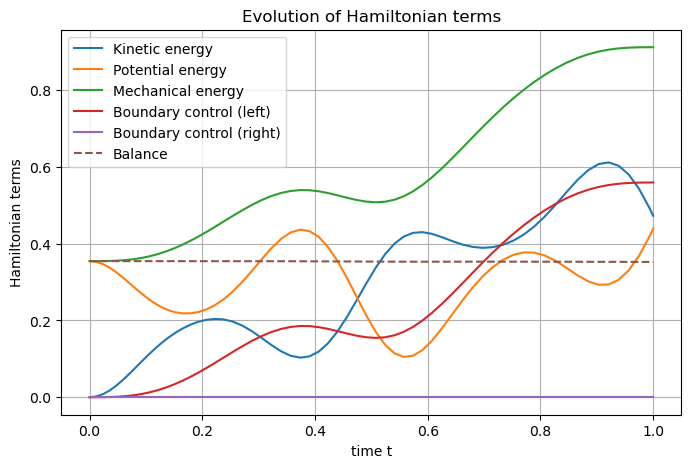

In [1]:
import scrimp as S
    
wave = S.DPHS("real")

domain = S.Domain("Interval", {"L": 1., "h": 0.01})
wave.set_domain(domain)

alpha_q = S.State("q", "Strain", "scalar-field")
alpha_p = S.State("p", "Linear momentum", "scalar-field")
wave.add_state(alpha_q)
wave.add_state(alpha_p)

e_q = S.CoState("e_q", "Stress", alpha_q)
e_p = S.CoState("e_p", "Velocity", alpha_p)
wave.add_costate(e_q)
wave.add_costate(e_p)

left_end = S.Control_Port("Boundary control (left)", "U_L", "Normal force", "Y_L", "Velocity", "scalar-field", region=10)
right_end = S.Control_Port("Boundary control (right)", "U_R", "Normal force", "Y_R", "Velocity", "scalar-field", region=11)
wave.add_control_port(left_end)
wave.add_control_port(right_end)

V_q = S.FEM("q", 2)
V_p = S.FEM("p", 1)
V_L = S.FEM("Boundary control (left)", 1)
V_R = S.FEM("Boundary control (right)", 1)
wave.add_FEM(V_q)
wave.add_FEM(V_p)
wave.add_FEM(V_L)
wave.add_FEM(V_R)

T = S.Parameter("T", "Young's modulus", "scalar-field", "1", "q")
rho = S.Parameter("rho", "Mass density", "scalar-field", "1 + x*(1-x)", "p")
wave.add_parameter(T)
wave.add_parameter(rho)

bricks = [
    # M matrix, on the flow side
    S.Brick("M_q", "q * Test_q", [1], dt=True, position="flow"),
    S.Brick("M_p", "p * Test_p", [1], dt=True, position="flow"),
    S.Brick("M_Y_L", "Y_L * Test_Y_L", [10], position="flow"),
    S.Brick("M_Y_R", "Y_R * Test_Y_R", [11], position="flow"),
    
    # J matrix, on the effort side
    S.Brick("D", "Grad(e_p) * Test_q", [1], position="effort"),

    S.Brick("-D^T", "-e_q * Grad(Test_p)", [1], position="effort"),
    S.Brick("B_L", "-U_L * Test_p", [10], position="effort"),
    S.Brick("B_R", "U_R * Test_p", [11], position="effort"),

    S.Brick("-B_L^T", "e_p * Test_Y_L", [10], position="effort"),
    S.Brick("-B_R^T", "-e_p * Test_Y_R", [11], position="effort"),
    
    # Constitutive relations
    S.Brick("-M_e_q", "-e_q * Test_e_q", [1]),
    S.Brick("CR_q", "q*T * Test_e_q", [1]),

    S.Brick("-M_e_p", "-e_p * Test_e_p", [1]),
    S.Brick("CR_p", "p/rho * Test_e_p", [1]),
    ]

for brick in bricks:
    wave.add_brick(brick)

## Initialize the problem
expression_left = "-sin(2*pi*t)"
expression_right = "0."
wave.set_control("Boundary control (left)", expression_left)
wave.set_control("Boundary control (right)", expression_right)

q_init = "2.*np.exp(-50.*(x-0.5)*(x-0.5))"
p_init = "0."
wave.set_initial_value("q", q_init)
wave.set_initial_value("p", p_init)

wave.solve()

wave.hamiltonian.set_name("Mechanical energy")
terms = [
    S.Term("Kinetic energy", "0.5*p*p/rho", [1]),
    S.Term("Potential energy", "0.5*q*T*q", [1]),
]

for term in terms:
    wave.hamiltonian.add_term(term)

wave.plot_Hamiltonian()